# Figure 2,3,4: Dataset fusion

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate
import sympy as sp

import ast

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from numba import njit

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

from bayern import ops

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-01-07 14:29:50

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

networkx  : 2.6.3
seaborn   : 0.11.1
pandas    : 1.2.4
bayern    : 0.1.0
numpy     : 1.20.3
matplotlib: 3.4.2
pymc3     : 3.11.4
sympy     : 1.8
theano    : 1.1.2
arviz     : 0.11.4
sys       : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]
scipy     : 1.6.2



## Helper functions for plotting

In [2]:
XSIZE = 7 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def savefig(name):
    """Helper function to save figures in desired formats"""
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

def generate_figure(n_col, n_row):
    """ Helper function to generate gridspec figures"""
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs

def plot_reactor(ax, input_substrates, output_substrates, enzymes, r_enzymes=0.1):
    """ Helper function to plot reactor schematics with inputs, outputs, an encapsulated enzymes"""
    WIDTH = 0.55
    HEIGHT = 0.45
    reactor = mpatches.FancyBboxPatch(
        ((1 - WIDTH) / 2, (1 - HEIGHT) / 2),
        width=WIDTH,
        height=HEIGHT,
        fill=False,
        edgecolor="black",
        linewidth=3,
        boxstyle=mpatches.BoxStyle("Round", pad=0.0, rounding_size=0.15),
    )
    reactor.set_clip_on(False)
    ax.add_patch(reactor)

    for i, substrate in enumerate(input_substrates):
        ax.annotate(
            text=substrate,
            xy=((1 - WIDTH) / 2, 0.5 - (len(input_substrates)-1) * 0.1/2 + i * 0.1),
            xytext=(0.1, 0.5 - (len(input_substrates)-1) * 0.1/2 + i * 0.1),
            arrowprops={"lw": 2, "arrowstyle": "-", "color": "black"},
            verticalalignment="center",
            horizontalalignment='right',
            fontsize=10,
            fontweight="medium",
        )
    for i, substrate in enumerate(output_substrates):
        ax.annotate(
            text=substrate,
            xy=((1 + WIDTH) / 2, 0.5 - (len(output_substrates)-1) * 0.1/2 + i * 0.1),
            xytext=((1 + WIDTH) / 2 + 0.15, 0.5 - (len(output_substrates)-1) * 0.1/2 + i * 0.1),
            arrowprops={
                        "arrowstyle": "<-",'connectionstyle':"arc3",
                        "lw": 2,  "color": "black",
            },
            verticalalignment="center",
            horizontalalignment='left',
            fontsize=10,
            fontweight="medium",
        )
    enzyme_colors = {'HK': "C2", 'GDH': "C3", "G6PDH": "C4"}
    indices = np.arange(0, len(enzymes), dtype=float) + 0.5
    r = np.sqrt(indices/len(enzymes))
    theta = np.pi * (1 + 5**0.5) * indices
    if len(enzymes) == 1:
        x_coords = np.array([0.5])
        y_coords = np.array([0.5])
    else:
        x_coords = r*np.cos(theta)*WIDTH/2.9 + 0.5
        y_coords = r*np.sin(theta)*HEIGHT/2.9 + 0.5

    for i, enzyme in enumerate(enzymes):
        with sns.color_palette("Pastel1"):
            if len(enzyme) > 3:
                FS = (10-len(enzyme))
            else: 
                FS = 10
            enzyme_patch = mpatches.Circle((x_coords[i], y_coords[i]), radius=r_enzymes, edgecolor="black",linewidth=1, fc=enzyme_colors[enzyme])
            enzyme_patch.set_clip_on(False)
            enzyme_label = ax.annotate(enzyme, xy=(x_coords[i], y_coords[i]), va='center_baseline', ha='center', fontsize=FS, fontweight="medium")
            ax.add_patch(enzyme_patch)
    return ax


## Loading of experimental datasets

In [4]:
import pathlib
DATA_DIR = pathlib.Path('../data/')
def load_kinetics_study(code):
    studies_files = DATA_DIR/ 'kinetic_studies.csv'
    studies_df = pd.read_csv(studies_files, index_col=0)
    study = studies_df.loc[code]
    data_df = pd.read_csv(DATA_DIR/study.data_path)
    data_df = data_df.assign(**{
        'code': code,
        'kf': study.flowrate/(study.volume*60),
        f'{study.enzyme}': study.enzyme_concentration,
        f'{study.enzyme}_batch': study.bead_batch
    })
    return data_df

def load_network_study(code):
    network_studies = pd.read_csv(f"{DATA_DIR}/network_studies.csv",
        converters={'enzyme_concentration': ast.literal_eval,
                    'bead_batch': ast.literal_eval,
                    'observables': ast.literal_eval
            }, index_col=0
    )
    study = network_studies.loc[code]
    return study



def load_HK_studies(studies):
    df_HK = pd.concat([load_kinetics_study(study) for study in studies], ignore_index=True)
    try:
        df_HK.ADP_obs = df_HK.ADP_obs.fillna(df_HK.G6P_obs)
    except AttributeError:
        df_HK = df_HK.assign(
            ADP_obs = df_HK.G6P_obs
        )
    df_HK.G6P_obs = df_HK.G6P_obs.fillna(df_HK.ADP_obs)
    df_HK = df_HK.assign(
        ATP_obs = df_HK.ATP_in - df_HK.G6P_obs,
        G_obs = df_HK.G_in - df_HK.G6P_obs
    )
    return df_HK

def load_GDH_studies(studies):
    df_GDH = pd.concat([load_kinetics_study(study) for study in studies], ignore_index=True)
    df_GDH = df_GDH.assign(
        NAD_obs = df_GDH.NAD_in - df_GDH.NADH_obs,
        G_obs = df_GDH.G_in - df_GDH.NADH_obs
    )
    return df_GDH

def load_HK_GDH_1_studies(studies):
    df_HK_GDH_1 = []

    for study in studies:
        study_info = load_network_study(study)
        data = pd.read_csv(f"{DATA_DIR}/{study_info.data_path}")
        data = data.assign(
            code = study,
            kf = study_info.flowrate/(study_info.volume*60),
            GDH = study_info.enzyme_concentration[0],
            HK = study_info.enzyme_concentration[1],
            GDH_batch = study_info.bead_batch[0],
            HK_batch = study_info.bead_batch[1]
        )
        data = data.assign(
            G6P_obs = lambda x: x["ADP_obs"],
            NAD_obs = lambda x: x['NAD_in'] - x['NADH_obs'],
            ATP_obs = lambda x: x['ATP_in'] - x['ADP_obs'],
            G_obs = lambda x: x["G_in"] - x["ADP_obs"] - x["NADH_obs"],
        )
        df_HK_GDH_1.append(data)
    df_HK_GDH_1 = pd.concat(df_HK_GDH_1)
    return df_HK_GDH_1

def load_HK_GDH_2_studies(studies):
    df_HK_GDH_2 = []

    for study in studies:
        study_info = load_network_study(study)
        data = pd.read_csv(f"{DATA_DIR}/{study_info.data_path}")
        data = data.assign(
            code = study,
            kf = study_info.flowrate/(study_info.volume*60),
            GDH = study_info.enzyme_concentration[0],
            HK = study_info.enzyme_concentration[1],
            GDH_batch = study_info.bead_batch[0],
            HK_batch = study_info.bead_batch[1]
        )
        df_HK_GDH_2.append(data)
    df_HK_GDH_2 = pd.concat(df_HK_GDH_2)
    return df_HK_GDH_2

In [5]:
def load_4_experiments():
    HK_studies = ["SNCA17", "SNCA18"]
    GDH_studies = ["SNCA14", "SNCA15"]
    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    return df_HK, df_GDH


def load_6_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11"]
    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    return df_HK, df_GDH


def load_16_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12", "SNKS18", "SNKS19"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003', 'SNNS004', 'SNNS005', 'SNNS006', 'SNNS007']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2

## Model creations

### Steady-state likelihood operator

In [6]:
def get_HK_GDH_likelihood(theta_set):
    G, NAD, NADH, ATP = sym_x = sp.symbols("G, NAD, NADH, ATP", real=True)
    k_GDH_cat, K_GDH_G, K_GDH_NAD, k_HK_cat, K_HK_G, K_HK_ATP = sym_phi = sp.symbols("k_GDH_cat, K_GDH_G, K_GDH_NAD, k_HK_cat, K_HK_G, K_HK_ATP", real=True)
    G_in, NAD_in, ATP_in, kf, GDH, HK = sym_theta = sp.symbols("G_in, NAD_in, ATP_in, kf, GDH, HK", real=True)

    sym_GDH_rate = k_GDH_cat*GDH*G*NAD/((K_GDH_G+G)*(K_GDH_NAD+NAD))
    sym_HK_rate = k_HK_cat*HK*G*ATP/((K_HK_G + G)*(K_HK_ATP+ATP))

    sym_rate_equations = [
        -sym_GDH_rate-sym_HK_rate + kf*(G_in - G),
        -sym_GDH_rate + kf*(NAD_in - NAD),
        +sym_GDH_rate - kf*NADH,
        -sym_HK_rate + kf*(ATP_in - ATP)
    ]

    sym_jac_x = sp.Matrix(sym_rate_equations).jacobian(sym_x)
    sym_jac_phi = sp.Matrix(sym_rate_equations).jacobian(sym_phi)
    sym_jac_theta = sp.Matrix(sym_rate_equations).jacobian(sym_theta)

    t = sp.symbols('t')
    num_rate_equations_ode = njit(sp.lambdify([t, sym_x, sym_phi, sym_theta], sym_rate_equations, "numpy"))
    num_jac_x_ode = njit(sp.lambdify([t, sym_x, sym_phi, sym_theta], sym_jac_x, "numpy"))

    num_rate_equations = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_rate_equations, "numpy"))
    num_jac_x = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_x, "numpy"))
    num_jac_phi = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_phi, "numpy"))
    num_jac_theta = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_theta, "numpy"))

    def find_root(fun, jac, phi, theta):
        return optimize.root(fun=fun, x0=[theta[0],theta[1],0.0, theta[2]], jac=jac, args=(phi, theta)).x
    num_grad_phi = njit(lambda x,phi,theta: np.dot(-np.linalg.inv(num_jac_x(x,phi,theta)),num_jac_phi(x,phi,theta)))
    num_grad_theta = njit(lambda x,phi,theta: np.dot(-np.linalg.inv(num_jac_x(x,phi,theta)),num_jac_theta(x,phi,theta)))

    SteadyStateOp = ops.RootFinderDatasetOp(num_rate_equations, num_jac_x, num_grad_phi, num_grad_theta, find_root, theta_set=theta_set)

    return SteadyStateOp

In [7]:
def get_simple_model(df_HK, df_GDH):
    exp_HK_idx, exp_HK_coords = df_HK.code.factorize(sort=True)
    exp_GDH_idx, exp_GDH_coords = df_GDH.code.factorize(sort=True)

    batch_GDH_idx, batch_GDH_coords = df_GDH.GDH_batch.factorize(sort=True)
    coords = {
        "exp_HK": exp_HK_coords,
        "exp_GDH": exp_GDH_coords,
        "batch_GDH": batch_GDH_coords,
    }

    print(f"Topologies: \t4\n\t{len(exp_HK_coords)} experiments HK\n\t{len(exp_GDH_coords)} experiments GDH")
    print(f"Experiments: \t{len(exp_HK_coords)+len(exp_GDH_coords)}")
    print(f"Datapoints: \t{len(df_HK)+len(df_GDH)}")
    print(f"GDH batches: \t{len(batch_GDH_coords)}")

    with pm.Model(coords=coords) as model:
        exp_HK_idx = pm.Data("exp_HK_idx", exp_HK_idx)
        exp_GDH_idx = pm.Data("exp_GDH_idx", exp_GDH_idx)
        batch_GDH_idx = pm.Data("batch_GDH_idx", batch_GDH_idx)

        k_cat_hyper = pm.Normal("k_cat_hyper", mu=1500, sigma=500)
        k_GDH_cat = pm.Uniform("k_GDH_cat", 1, k_cat_hyper, dims="batch_GDH")
        k_HK_cat = pm.Uniform("k_HK_cat", 1, k_cat_hyper)

        K_GDH_G = pm.Uniform("K_GDH_G", 1, 20_000)
        K_GDH_NAD = pm.Uniform("K_GDH_NAD", 1, 20_000)

        K_HK_G = pm.Uniform("K_HK_G", 1, 4000)
        K_HK_ATP  = pm.Uniform("K_HK_ATP", 1, 6000)

        sigma = pm.Exponential("sigma", 10.0)

        sigma_HK = pm.Exponential("sigma_HK", sigma, dims="exp_HK")

        HK_obs = pm.Normal("HK_obs",
                    mu=(-k_HK_cat*df_HK.HK.values*df_HK.G_obs.values*df_HK.ATP_obs.values/(df_HK.kf.values*(K_HK_G+df_HK.G_obs.values)*(K_HK_ATP + df_HK.ATP_obs.values))) + df_HK.G_in.values,
                    sigma=sigma_HK[exp_HK_idx],
                    observed=(df_HK.G_obs.values)
        )

        sigma_GDH = pm.Exponential("sigma_GDH", sigma, dims="exp_GDH")
        GDH_obs = pm.Normal("GDH_obs",
                    mu=-k_GDH_cat[batch_GDH_idx]*df_GDH.GDH.values*df_GDH.G_obs.values*df_GDH.NAD_obs.values/(
                            df_GDH.kf.values*(K_GDH_G+df_GDH.G_obs.values)*(K_GDH_NAD+df_GDH.NAD_obs.values )
                        ) + df_GDH.G_in.values,
                    sigma=sigma_GDH[exp_GDH_idx],
                    observed=(df_GDH.G_obs.values)
        )

    return model


In [8]:
def get_complex_model(df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2):
    exp_HK_idx, exp_HK_coords = df_HK.code.factorize(sort=True)
    exp_GDH_idx, exp_GDH_coords = df_GDH.code.factorize(sort=True)

    batch_GDH_idx, batch_GDH_coords = df_GDH.GDH_batch.factorize(sort=True)
    batch_GDH_idx_HK_GDH_2, batch_GDH_coords_HK_GDH_2 = df_HK_GDH_2.GDH_batch.factorize(sort=True)

    exp_HK_GDH_1_idx, exp_HK_GDH_1_coords = df_HK_GDH_1.code.factorize(sort=True)
    exp_HK_GDH_2_idx, exp_HK_GDH_2_coords = df_HK_GDH_2.code.factorize(sort=True)

    GDH_batch_lookup = dict(zip(batch_GDH_coords, range(len(batch_GDH_coords))))
    batch_GDH_idx_HK_GDH_1 = df_HK_GDH_1.GDH_batch.replace(GDH_batch_lookup).values
    batch_GDH_idx_HK_GDH_2 = df_HK_GDH_2.GDH_batch.replace(GDH_batch_lookup).values

    coords = {
        "exp_HK": exp_HK_coords,
        "exp_GDH": exp_GDH_coords,
        "exp_HK_GDH_1": exp_HK_GDH_1_coords,
        "exp_HK_GDH_2": exp_HK_GDH_2_coords,
        "batch_GDH": batch_GDH_coords,
    }

    print(f"Topologies: \t4\n\t{len(exp_HK_coords)} experiments HK\n\t{len(exp_GDH_coords)} experiments GDH\n\t{len(exp_HK_GDH_1_coords)} experiments HK+GDH (complete observability)\n\t{len(exp_HK_GDH_2_coords)} experiments HK+GDH (partial observability)")
    print(f"Experiments: \t{len(exp_HK_coords)+len(exp_GDH_coords)+len(exp_HK_GDH_1_coords)+len(exp_HK_GDH_2_coords)}")
    print(f"Datapoints: \t{len(df_HK)+len(df_GDH)+len(df_HK_GDH_1)+len(df_HK_GDH_2)}")
    print(f"GDH batches: \t{len(batch_GDH_coords)}")

    with pm.Model(coords=coords) as model:
        exp_HK_idx = pm.Data("exp_HK_idx", exp_HK_idx)
        exp_GDH_idx = pm.Data("exp_GDH_idx", exp_GDH_idx)
        exp_HK_GDH_1_idx = pm.Data("exp_HK_GDH_1_idx", exp_HK_GDH_1_idx)
        exp_HK_GDH_2_idx = pm.Data("exp_HK_GDH_2_idx", exp_HK_GDH_2_idx)

        batch_GDH_idx = pm.Data("batch_GDH_idx", batch_GDH_idx)
        batch_GDH_idx_HK_GDH_1 = pm.Data("batch_GDH_idx_HK_GDH_1", batch_GDH_idx_HK_GDH_1)

        k_cat_hyper = pm.Normal("k_cat_hyper", mu=1500, sigma=500)
        k_GDH_cat = pm.Uniform("k_GDH_cat", 1, k_cat_hyper, dims="batch_GDH")
        k_HK_cat = pm.Uniform("k_HK_cat", 1, k_cat_hyper)

        K_GDH_G = pm.Uniform("K_GDH_G", 1, 20_000)
        K_GDH_NAD = pm.Uniform("K_GDH_NAD", 1, 20_000)

        K_HK_G = pm.Uniform("K_HK_G", 1, 4000)
        K_HK_ATP  = pm.Uniform("K_HK_ATP", 1, 6000)

        sigma = pm.Exponential("sigma", 10.0)

        sigma_HK = pm.Exponential("sigma_HK", sigma, dims="exp_HK")

        HK_obs = pm.Normal("HK_obs",
                    mu=(-k_HK_cat*df_HK.HK.values*df_HK.G_obs.values*df_HK.ATP_obs.values/(df_HK.kf.values*(K_HK_G+df_HK.G_obs.values)*(K_HK_ATP + df_HK.ATP_obs.values))) + df_HK.G_in.values,
                    sigma=sigma_HK[exp_HK_idx],
                    observed=(df_HK.G_obs.values)
        )

        sigma_GDH = pm.Exponential("sigma_GDH", sigma, dims="exp_GDH")
        GDH_obs = pm.Normal("GDH_obs",
                    mu=-k_GDH_cat[batch_GDH_idx]*df_GDH.GDH.values*df_GDH.G_obs.values*df_GDH.NAD_obs.values/(
                            df_GDH.kf.values*(K_GDH_G+df_GDH.G_obs.values)*(K_GDH_NAD+df_GDH.NAD_obs.values )
                        ) + df_GDH.G_in.values,
                    sigma=sigma_GDH[exp_GDH_idx],
                    observed=(df_GDH.G_obs.values)
        )

        sigma_HK_GDH_1 = pm.Exponential("sigma_HK_GDH_1", sigma, dims="exp_HK_GDH_1")
        HK_GDH_1_obs = pm.Normal("HK_GDH_1_obs",
                    mu=-k_GDH_cat[batch_GDH_idx_HK_GDH_1]*df_HK_GDH_1.GDH.values*df_HK_GDH_1.G_obs.values*df_HK_GDH_1.NAD_obs.values/(
                        df_HK_GDH_1.kf.values*(K_GDH_G+df_HK_GDH_1.G_obs.values)*(K_GDH_NAD+df_HK_GDH_1.NAD_obs.values)
                        )
                    -k_HK_cat*df_HK_GDH_1.HK.values*df_HK_GDH_1.G_obs.values*df_HK_GDH_1.ATP_obs.values/(df_HK_GDH_1.kf.values*(K_HK_G+df_HK_GDH_1.G_obs.values)*(K_HK_ATP + df_HK_GDH_1.ATP_obs.values)),
                    sigma=sigma_HK_GDH_1[exp_HK_GDH_1_idx],
                    observed=(df_HK_GDH_1.G_obs.values - df_HK_GDH_1.G_in.values)
        )
        
        sigma_HK_GDH_2 = pm.Exponential("sigma_HK_GDH_2", sigma, dims="exp_HK_GDH_2")
        theta = df_HK_GDH_2[["G_in", "NAD_in", "ATP_in", "kf", "GDH", "HK"]].values
        likelihood = get_HK_GDH_likelihood(theta)

        HK_GDH_2_obs = pm.Normal(f"HK_GDH_2_obs",
                mu=likelihood(tt.stack([
                    k_GDH_cat[1], K_GDH_G, K_GDH_NAD, k_HK_cat, K_HK_G, K_HK_ATP
                ]))[:,2],
                sigma=sigma_HK_GDH_2[exp_HK_GDH_2_idx],
                observed=df_HK_GDH_2.NADH_obs.values
        )

    return model


## Model sampling

In [9]:
def sample_4_experiments():
    df_GDH, df_HK = load_4_experiments()
    model = get_simple_model(df_GDH, df_HK)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata_4exp.nc")

def sample_6_experiments():
    df_GDH, df_HK = load_6_experiments()
    model = get_simple_model(df_GDH, df_HK)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata_6exp.nc")

def sample_16_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_16_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata_16exp.nc")

In [10]:
sample_4_experiments()

Topologies: 	4
	2 experiments HK
	2 experiments GDH
Experiments: 	4
Datapoints: 	22
GDH batches: 	1


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
sample_6_experiments()

Topologies: 	4
	3 experiments HK
	3 experiments GDH
Experiments: 	6
Datapoints: 	34
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
sample_16_experiments()

Topologies: 	4
	4 experiments HK
	6 experiments GDH
	1 experiments HK+GDH (complete observability)
	6 experiments HK+GDH (partial observability)
Experiments: 	17
Datapoints: 	124
GDH batches: 	3


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2457 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
idata_4exp = az.from_netcdf("idata_4exp.nc")
idata_6exp = az.from_netcdf("idata_6exp.nc")
idata_16exp = az.from_netcdf("idata_16exp.nc")

posterior_4exp_df = idata_4exp.to_dataframe(['posterior'], include_coords=False)
posterior_6exp_df = idata_6exp.to_dataframe(['posterior'], include_coords=False)
posterior_16exp_df = idata_16exp.to_dataframe(['posterior'], include_coords=False)

## Figures

### Figure 2

In [13]:
df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2 = load_16_experiments()

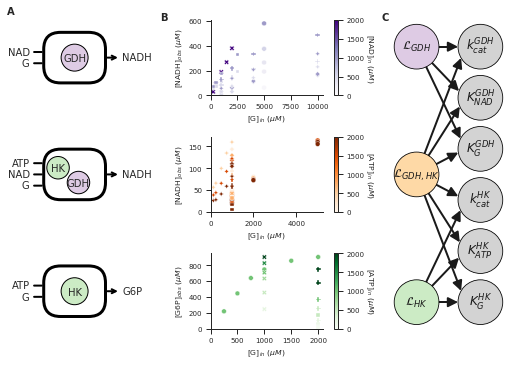

In [14]:
fig, gs = generate_figure(3,3)
fig.set_size_inches(XSIZE, YSIZE*1.0)

ax_GDH = fig.add_subplot(gs[0,0])
ax_HK = fig.add_subplot(gs[2,0])
ax_GDH_HK = fig.add_subplot(gs[1,0])
ax_GDH.axis("off")
ax_HK.axis("off")
ax_GDH_HK.axis("off")
ax_GDH.set_aspect("equal")
ax_HK.set_aspect("equal")
ax_GDH_HK.set_aspect("equal")
ax_GDH.set_ylim(0.3,0.7)
ax_HK.set_ylim(0.3,0.7)
ax_GDH_HK.set_ylim(0.3,0.7)

plot_reactor(ax_GDH, ['G', 'NAD'], ['NADH'], ['GDH'], r_enzymes=0.12)
plot_reactor(ax_HK, ['G', 'ATP'], ['G6P'], ['HK'], r_enzymes=0.12)
plot_reactor(ax_GDH_HK, ['G', 'NAD', 'ATP'], ['NADH'], ['GDH', 'HK'], r_enzymes=0.1)

ax_1 = fig.add_subplot(gs[0,1])
norm = plt.Normalize(0, 2000)
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
sm.set_array([])
sns.scatterplot(ax=ax_1, data=df_GDH, x='G_in', y='NADH_obs', hue='NAD_in', palette='Purples', style='code', hue_norm=norm)
sns.despine(ax=ax_1)
ax_1.set_xlim(0)
ax_1.set_ylim(0)
ax_1.set_xlabel(r"$[$G$]_{in}~(\mu M)$")
ax_1.set_ylabel(r"$[$NADH$]_{obs}~(\mu M)$")

ax_1.get_legend().remove()
cbar = ax_1.figure.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 10
cbar.set_label(r"$[$NAD$]_{in}~(\mu M)$", rotation=270)

ax_2 = fig.add_subplot(gs[1,1])
norm = plt.Normalize(0, 2000)
sm = plt.cm.ScalarMappable(cmap="Oranges", norm=norm)
sm.set_array([])
sns.scatterplot(ax=ax_2, data=df_HK_GDH_2, x='G_in', y='NADH_obs', hue='ATP_in', style='code', palette='Oranges', hue_norm=norm)
sns.despine(ax=ax_2)
ax_2.set_xlim(0)
ax_2.set_ylim(0)
ax_2.set_xlabel(r"$[$G$]_{in}~(\mu M)$")
ax_2.set_ylabel(r"$[$NADH$]_{obs}~(\mu M)$")
ax_2.get_legend().remove()
cbar = ax_2.figure.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 10
cbar.set_label(r"$[$ATP$]_{in}~(\mu M)$", rotation=270)

ax_3 = fig.add_subplot(gs[2,1])
norm = plt.Normalize(0, 2000)
sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
sm.set_array([])
sns.scatterplot(ax=ax_3, data=df_HK, x='G_in', y='G6P_obs', hue='ATP_in', style='code', palette='Greens', hue_norm=norm)
sns.despine(ax=ax_3)
ax_3.set_xlim(0)
ax_3.set_ylim(0)
ax_3.set_xlabel(r"$[$G$]_{in}~(\mu M)$")
ax_3.set_ylabel(r"$[$G6P$]_{obs}~(\mu M)$")
ax_3.get_legend().remove()
cbar = ax_3.figure.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 10
cbar.set_label(r"$[$ATP$]_{in}~(\mu M)$", rotation=270)

""" Probabilistic model"""
ax_4 = fig.add_subplot(gs[0:3,2])
ax_4.axis("off")

model_graph = nx.DiGraph()
model_graph.add_edge( r"$\mathcal{L}_{GDH}$", r"$k_{cat}^{GDH}$")
model_graph.add_edge( r"$\mathcal{L}_{GDH}$", r"$K_{G}^{GDH}$")
model_graph.add_edge( r"$\mathcal{L}_{GDH}$", r"$K_{NAD}^{GDH}$")
model_graph.add_edge(r"$\mathcal{L}_{GDH,HK}$", r"$k_{cat}^{GDH}$",)
model_graph.add_edge(r"$\mathcal{L}_{GDH,HK}$", r"$k_{cat}^{HK}$",)
model_graph.add_edge(r"$\mathcal{L}_{GDH,HK}$", r"$K_{G}^{GDH}$",)
model_graph.add_edge(r"$\mathcal{L}_{GDH,HK}$", r"$K_{NAD}^{GDH}$",)
model_graph.add_edge(r"$\mathcal{L}_{GDH,HK}$", r"$K_{G}^{HK}$",)
model_graph.add_edge(r"$\mathcal{L}_{GDH,HK}$", r"$K_{ATP}^{HK}$",)
model_graph.add_edge( r"$\mathcal{L}_{HK}$", r"$k_{cat}^{HK}$")
model_graph.add_edge( r"$\mathcal{L}_{HK}$", r"$K_{G}^{HK}$")
model_graph.add_edge( r"$\mathcal{L}_{HK}$", r"$K_{ATP}^{HK}$")

with sns.color_palette("Pastel1"):
    left = nx.bipartite.sets(model_graph)[0]
    pos= nx.bipartite_layout(model_graph, list(left)[::-1], scale=0.8)

    pos = pos | {
        '$\\mathcal{L}_{GDH}$':  np.array([-0.8, 0.45]),
        '$\\mathcal{L}_{GDH,HK}$':  np.array([-0.8 ,  0.0]),
        '$\\mathcal{L}_{HK}$': np.array([-0.8 , -0.45]),
        '$k_{cat}^{GDH}$': np.array([0.4 , 0.45]),
        '$K_{NAD}^{GDH}$': np.array([ 0.4 , 0.27]),
        '$K_{G}^{GDH}$': np.array([ 0.4 , 0.09]),
        '$k_{cat}^{HK}$': np.array([ 0.4 , -0.09]),
        '$K_{ATP}^{HK}$': np.array([0.4 , -0.27]),
        '$K_{G}^{HK}$': np.array([0.4 , -0.45])
        }
    node_colors = ['C3', 'lightgrey' , 'lightgrey', 'lightgrey', 'C4', 'lightgrey', 'lightgrey', 'lightgrey', 'C2' ]
    nx.draw(model_graph, pos, ax=ax_4, with_labels=True, node_size=2000, node_color=node_colors, 
        width=2, edgecolors='black',
    arrowstyle='-|>', arrowsize=20, connectionstyle="arc,armB=-15"
    )
    ax_4.margins(x=0.3)


ax_GDH.text(-0.1,1.46, 'A', transform=ax_GDH.transAxes, weight="bold", size=10)
ax_1.text(-0.45, 0.99, 'B', transform=ax_1.transAxes, weight="bold", size=10)
ax_4.text(-0.1, 1.0, 'C', transform=ax_4.transAxes, weight="bold", size=10)

savefig("fig_datafusion_alta")
plt.show()

### Figure 3

In [15]:
def plot_ridgeplots(fig, gs, n_plots, data, start_color=0):
    pal = sns.cubehelix_palette(n_plots, start=start_color, rot=-.2, dark=0.4, light=0.9)
    axes = [fig.add_subplot(gs[i,0]) for i in range(n_plots)]

    for i in range(n_plots):
        sns.kdeplot(data[i], ax=axes[i], fill=True, clip_on=True, alpha=0.6, color=pal[i])
        sns.kdeplot(data[i], ax=axes[i], fill=False, clip_on=True, color="black", lw=.2)

    y_max = max(axes[-1].get_yticks())
    x_min, x_max = min(axes[-1].get_xticks()),  max(axes[-1].get_xticks())
    for i, ax in enumerate(axes):
        # ax.set_ylim(0, y_max)
        ymax = max(ax.get_yticks())*(n_plots - i)
        ax.set_ylim(0, ymax)
        ax.set_xlim(x_min, x_max)
        ax.patch.set_alpha(0)

    for ax in axes[:-1]:
        ax.axis("off")
        sns.despine(ax=ax, left=True, bottom=True)

    axes[-1].set_yticks([])
    axes[-1].set_ylabel("")
    sns.despine(ax=axes[-1], left=True)

    return axes, pal

/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


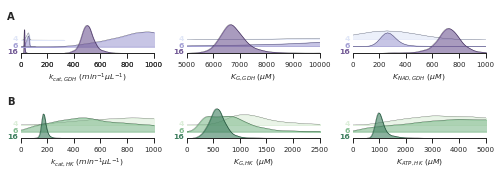

In [16]:
fig, gs = generate_figure(3,2)
fig.set_constrained_layout(False)
fig.set_tight_layout(True)
fig.set_size_inches(XSIZE, YSIZE*1.5/3)

HSPACE = -0.8
N_DATASETS = 3
gs_rp = gs[0,0].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_4exp_df['k_GDH_cat[0]'], 
                                            posterior_6exp_df['k_GDH_cat[0]'],
                                            posterior_16exp_df['k_GDH_cat[0]'],
                                            ], 
                            start_color=0.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]
axes[-1].set_xlabel("")

axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            np.zeros(4000), 
                                            posterior_6exp_df['k_GDH_cat[1]'],
                                            posterior_16exp_df['k_GDH_cat[1]']], 
                            start_color=0.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]

axes[0].text(-0.1, 0.6, 'A', transform=axes[0].transAxes, weight="bold", size=10)
axes[0].text(-0.02, 0.03, "4", fontweight="bold", color=pal[0],
            ha="right", va="center", transform=axes[0].transAxes)
axes[1].text(-0.02, 0.03, "6", fontweight="bold", color=pal[1],
            ha="right", va="center", transform=axes[1].transAxes)
axes[2].text(-0.02, 0.03, "16", fontweight="bold", color=pal[2],
            ha="right", va="center", transform=axes[2].transAxes)
axes[2].set_xlabel(r"$k_{cat,GDH}~(min^{-1}\mu L^{-1})$")
gs_rp = gs[0,1].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_4exp_df['K_GDH_G'], 
                                            posterior_6exp_df['K_GDH_G'],
                                            posterior_16exp_df['K_GDH_G']], 
                            start_color=0.4
                            )
[ax.set_xlim(5000, 10000) for ax in axes]
axes[0].text(-0.02, 0.03, "4", fontweight="bold", color=pal[0],
            ha="right", va="center", transform=axes[0].transAxes)
axes[1].text(-0.02, 0.03, "6", fontweight="bold", color=pal[1],
            ha="right", va="center", transform=axes[1].transAxes)
axes[2].text(-0.02, 0.03, "16", fontweight="bold", color=pal[2],
            ha="right", va="center", transform=axes[2].transAxes)
axes[2].set_xlabel(r"$K_{G,GDH}~(\mu M)$")

gs_rp = gs[0,2].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_4exp_df['K_GDH_NAD'], 
                                            posterior_6exp_df['K_GDH_NAD'],
                                            posterior_16exp_df['K_GDH_NAD']], 
                            start_color=0.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]
axes[0].text(-0.02, 0.03, "4", fontweight="bold", color=pal[0],
            ha="right", va="center", transform=axes[0].transAxes)
axes[1].text(-0.02, 0.03, "6", fontweight="bold", color=pal[1],
            ha="right", va="center", transform=axes[1].transAxes)
axes[2].text(-0.02, 0.03, "16", fontweight="bold", color=pal[2],
            ha="right", va="center", transform=axes[2].transAxes)
axes[2].set_xlabel(r"$K_{NAD,GDH}~(\mu M)$")

gs_rp = gs[1,0].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_4exp_df['k_HK_cat'], 
                                            posterior_6exp_df['k_HK_cat'],
                                            posterior_16exp_df['k_HK_cat']], 
                            start_color=2.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]
axes[0].text(-0.1, 0.6, 'B', transform=axes[0].transAxes, weight="bold", size=10)
axes[0].text(-0.02, 0.03, "4", fontweight="bold", color=pal[0],
            ha="right", va="center", transform=axes[0].transAxes)
axes[1].text(-0.02, 0.03, "6", fontweight="bold", color=pal[1],
            ha="right", va="center", transform=axes[1].transAxes)
axes[2].text(-0.02, 0.03, "16", fontweight="bold", color=pal[2],
            ha="right", va="center", transform=axes[2].transAxes)
axes[2].set_xlabel(r"$k_{cat,HK}~(min^{-1}\mu L^{-1})$")

gs_rp = gs[1,1].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_4exp_df['K_HK_G'], 
                                            posterior_6exp_df['K_HK_G'],
                                            posterior_16exp_df['K_HK_G']], 
                            start_color=2.4
                            )
[ax.set_xlim(0, 2500) for ax in axes]
axes[0].text(-0.02, 0.03, "4", fontweight="bold", color=pal[0],
            ha="right", va="center", transform=axes[0].transAxes)
axes[1].text(-0.02, 0.03, "6", fontweight="bold", color=pal[1],
            ha="right", va="center", transform=axes[1].transAxes)
axes[2].text(-0.02, 0.03, "16", fontweight="bold", color=pal[2],
            ha="right", va="center", transform=axes[2].transAxes)
axes[2].set_xlabel(r"$K_{G,HK}~(\mu M)$")

gs_rp = gs[1,2].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_4exp_df['K_HK_ATP'], 
                                            posterior_6exp_df['K_HK_ATP'],
                                            posterior_16exp_df['K_HK_ATP']], 
                            start_color=2.4
                            )
[ax.set_xlim(0, 5000) for ax in axes]
axes[0].text(-0.02, 0.03, "4", fontweight="bold", color=pal[0],
            ha="right", va="center", transform=axes[0].transAxes)
axes[1].text(-0.02, 0.03, "6", fontweight="bold", color=pal[1],
            ha="right", va="center", transform=axes[1].transAxes)
axes[2].text(-0.02, 0.03, "16", fontweight="bold", color=pal[2],
            ha="right", va="center", transform=axes[2].transAxes)
axes[2].set_xlabel(r"$K_{ATP,HK}~(\mu M)$")
sns.despine(ax=axes[0], left=False)

savefig("fig_datafusion_altb")

### Figure 4

In [17]:
df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2 = load_16_experiments()

model = get_complex_model(df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2)

with model:
    post_pred_16exp_HK = pm.sample_posterior_predictive(idata_16exp, var_names=["HK_obs"])

SNCA18_df = df_HK[df_HK.code == "SNCA18"]
SCNA18_pred = post_pred_16exp_HK['HK_obs'][:,SNCA18_df.index]

SNKS04_df = df_HK[df_HK.code == "SNKS04"]
SNKS04_pred = post_pred_16exp_HK['HK_obs'][:,SNKS04_df.index]
SNKS03_df = df_HK[df_HK.code == "SNKS03"]
SNKS03_pred = post_pred_16exp_HK['HK_obs'][:,SNKS03_df.index]

Topologies: 	4
	4 experiments HK
	6 experiments GDH
	1 experiments HK+GDH (complete observability)
	6 experiments HK+GDH (partial observability)
Experiments: 	17
Datapoints: 	124
GDH batches: 	3


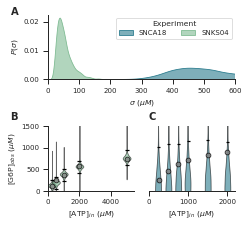

In [18]:
with sns.color_palette("crest"):
    fig = plt.figure(figsize=(3.3, 3.0), constrained_layout=True)
    gs = fig.add_gridspec(2, 2)

    ax_0 = fig.add_subplot(gs[1,1])
    norm = plt.Normalize(0, 2000)
    sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
    sm.set_array([])

    violin_parts = ax_0.violinplot(SNCA18_df.G_in.values[None,:] - SCNA18_pred, positions=SNCA18_df.ATP_in, 
    showextrema=False, widths=150, quantiles=[[0.025, 0.975]]*len(SNCA18_df))
    for pc in violin_parts['bodies']:
        pc.set_facecolor('C3')
        pc.set_alpha(0.6)
        pc.set_edgecolor('black')
    violin_parts['cquantiles'].set_colors("black")
    ax_0.scatter(SNCA18_df.ATP_in, SNCA18_df.G6P_obs, color="grey", alpha=0.8, ec='black', zorder=10)
    ax_0.set_ylim(0, 1500)

    ax_0.set_xlim(0, 2200)
    ax_0.get_yaxis().set_visible(False)
    sns.despine(ax=ax_0, left=True)
    ax_0.set_xlabel(r"$[$ATP$]_{in}~(\mu M)$")

    ax_1 = fig.add_subplot(gs[1,0])

    violin_parts = ax_1.violinplot(SNKS04_df.G_in.values[None,:] - SNKS04_pred, positions=SNKS04_df.ATP_in, 
    showextrema=False, widths=500, quantiles=[[0.025, 0.975]]*len(SNKS04_df), points=100)
    for pc in violin_parts['bodies']:
        pc.set_facecolor('C0')
        pc.set_alpha(0.6)
        pc.set_edgecolor('black')
    violin_parts['cquantiles'].set_colors("black")
    ax_1.scatter(SNKS04_df.ATP_in, SNKS04_df.G6P_obs, color="grey", alpha=0.8, ec='black', zorder=10)
    ax_1.set_ylim(0, 1500)
    ax_1.set_xlim(0, 5500)
    ax_1.set_ylabel(r"$[$G6P$]_{obs}~(\mu M)$")
    ax_1.set_xlabel(r"$[$ATP$]_{in}~(\mu M)$")

    ax_2 = fig.add_subplot(gs[0,:])

    i=1
    sns.kdeplot(posterior_16exp_df[f'sigma_HK[{i}]'], ax=ax_2, fill=True, color="C3", label="SNCA18", alpha=0.6)
    i=3
    sns.kdeplot(posterior_16exp_df[f'sigma_HK[{i}]'], ax=ax_2, fill=True, color="C0", label="SNKS04", alpha=0.6)

    lines2, labels2 = ax_2.get_legend_handles_labels()
    ax_2.set_xlabel(r"$\sigma~(\mu M)$")
    ax_2.set_ylabel(r"$P(\sigma)$")
    ax_2.set_xlim(0, 600)

    sns.despine(ax=ax_1)
    sns.despine(ax=ax_2)

    ax_0.text(-0.0, 1.1, 'C', transform=ax_0.transAxes, weight="bold", size=10)
    ax_1.text(-0.44, 1.1, 'B', transform=ax_1.transAxes, weight="bold", size=10)
    ax_2.text(-0.2, 0.99, 'A', transform=ax_2.transAxes, weight="bold", size=10)

    ax_2.legend(
        title="Experiment",
        fancybox=True,
        ncol=2,
        loc="upper right",
    )


    savefig("fig_datafusionb")
    plt.show()